### Loading Packages

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.preprocessing import Imputer    # 옛날 코드
from sklearn.impute import SimpleImputer   # Null Value 처리

from sklearn.preprocessing import PolynomialFeatures   # Numeric 피쳐를 곱해서 Feature Engineering을 편하게 하기위해
from sklearn.preprocessing import StandardScaler

# Selection: 너무많은 Feature를 생성 시에 다중 공선성 등 문제가 발생 -> 중요한 Feature를 선택
from sklearn.feature_selection import VarianceThreshold   # 변수의 Variance가 작다는 것은 정보를 적게 가지고 있다는 것, 이를 가지고 selection
from sklearn.feature_selection import SelectFromModel   # 모델마다 변수에 중요도를 매김, 이를 가지고 selection
# Selection 시 하나의 모델로만 변수를 선택하게 되면 모델별로 중요한 변수가 치우칠 수 있음, 여러 알고리즘을 가지고 해보는게 좋다. (트리, Linear, SVM 등)
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

### Column 설명
- 컬럼명 뒤쪽에 붙어있는 것
    - bin = 바이너리
    - cat = 카테고리
    - 없는것은 = continuous or ordinal
    - Missing Value = -1
    - Target = 0, 1

In [11]:
# 디버깅 시 팁   /  Data가 너무 많은 경우 디버깅을 빠르게 할 수 없으므로 데이터 수를 줄여서 사용

DEBUG = False   # True는 디버그 모드, False는 전체 데이터 사용

if DEBUG:
    NROWS = 500000
else:
    NROWS = None

### EDA할 때 데이터가 너무 많으면 5만개~10만개, 100만개 정도로만 하자. PC사양에 따라 적절하게

In [12]:
train = pd.read_csv('../input/porto-seguro-safe-driver-prediction/train.csv', nrows=NROWS)
test = pd.read_csv('../input/porto-seguro-safe-driver-prediction/test.csv', nrows=NROWS)

train = train.sample(frac=0.1)    # 위의 디버깅 방법외에도 이 코드로 비율을 뽑아서 쓸 수 있음

In [13]:
# 클래스의 불균형이 걱정되면 아래의 코드 StratifiedKFold 사용해서 샘플링

# from sklearn.model_selection import StratifiedKFold
# fold = StratifiedKFold(n_splits=10, random_state=38)
# for train_idx, val_idx in fold.split(train, train['target']):
#     break
# train = train.iloc[train_idx]

In [14]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
265034,662256,0,1,1,7,0,6,1,0,0,0,0,0,0,0,0,5,1,0,0,0.6,0.4,1.112991,11,0,-1,0,-1,11,0,1,2,1,3,2,0.424264,1.083974,0.434971,3.464102,0.4,0.3,0.8,4,2,8,3,11,2,2,6,1,5,11,0,1,0,0,0,1
217273,542828,0,0,2,0,1,4,0,0,0,1,0,0,0,0,0,9,1,0,0,0.6,0.2,0.588430,4,1,-1,0,0,11,1,1,0,1,103,3,0.316228,0.553856,0.358329,2.236068,0.0,0.2,0.9,4,2,9,4,10,3,9,8,1,3,9,0,1,1,1,1,1
405231,1012857,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.2,0.2,-1.000000,7,1,0,0,1,11,1,1,2,1,99,2,0.316228,0.596720,0.303315,2.828427,0.7,0.2,0.9,2,2,8,2,11,2,17,1,3,1,4,0,0,1,0,0,1
537512,1343380,0,0,3,3,0,0,0,1,0,0,0,0,0,0,0,4,0,0,0,0.9,0.2,0.582022,7,1,-1,0,-1,1,1,0,2,1,52,3,0.374166,0.863421,0.359861,3.741657,0.4,0.2,0.1,1,0,4,3,10,3,13,5,0,2,10,0,1,1,0,1,0
563096,1407805,0,2,1,7,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.2,0.2,-1.000000,10,1,-1,0,1,0,1,1,0,1,87,3,0.316228,0.709222,0.361525,3.316625,0.7,0.1,0.0,3,2,7,2,8,2,4,5,3,1,6,0,1,0,1,1,0


In [15]:
# 변수 중 카테고리컬 피처만을 뽑기

cat_cols= [col for col in train.columns if 'cat' in col]    # cat이라는 단어가 포함되어있는 컬럼
cat_cols

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [16]:
# 카테고리컬 피처의 분포보기 (정수형인지, 몇개의 Unique한 클래스를 가지는지)
# Categorical의 13번째 피처는 104개의 클래스 = high cardinality(고차원),  따라서 원핫대신 다른 Encoding 방법 사용

for col in cat_cols:
    print(col, train[col].nunique(), train[col].unique())

ps_ind_02_cat 5 [ 1  2  3  4 -1]
ps_ind_04_cat 3 [ 0  1 -1]
ps_ind_05_cat 8 [ 6  4  0  3  1 -1  5  2]
ps_car_01_cat 13 [11  4  7 10  6  8  9  5  3  0  1 -1  2]
ps_car_02_cat 2 [0 1]
ps_car_03_cat 3 [-1  0  1]
ps_car_04_cat 10 [0 2 9 1 3 8 6 5 4 7]
ps_car_05_cat 3 [-1  0  1]
ps_car_06_cat 18 [11  1  0 14  9 16  6  4 15 10 17 13  7  8  2  5  3 12]
ps_car_07_cat 3 [ 0  1 -1]
ps_car_08_cat 2 [1 0]
ps_car_09_cat 6 [ 2  0  1  3  4 -1]
ps_car_10_cat 3 [1 0 2]
ps_car_11_cat 104 [  3 103  99  52  87  38   1  82  64  98 104   2  10  21  69  70  32  84
  22  37  65  60  48   5  44  83  68  92  27  86 100  77  28  74  80  39
  66  78  29  71  12  67  91  40  11  20 101  34   6  19  85  49  73  61
   9  96  43  17  23  72  76  26   8  15   4  79   7  46  47  54  51  36
  57  53  24 102  55  90  93  16  13  50  59  42  31  30  88  89  14  33
  94  35  62  58  25  75  63  45  41  95  97  81  56  18]


In [17]:
# Train 데이터의 중복여부 확인,  중복이 존재하지 않음

train.drop_duplicates()
train.shape

(59521, 59)

In [18]:
# 변수의 정보확인, 모두 int 및 Float /  Object형 즉, String형태의 컬럼은 없음
# Null Data도 확인 / 여기는 -1로 다 치환되어 있기 때문에 없음

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59521 entries, 265034 to 259141
Data columns (total 59 columns):
id                59521 non-null int64
target            59521 non-null int64
ps_ind_01         59521 non-null int64
ps_ind_02_cat     59521 non-null int64
ps_ind_03         59521 non-null int64
ps_ind_04_cat     59521 non-null int64
ps_ind_05_cat     59521 non-null int64
ps_ind_06_bin     59521 non-null int64
ps_ind_07_bin     59521 non-null int64
ps_ind_08_bin     59521 non-null int64
ps_ind_09_bin     59521 non-null int64
ps_ind_10_bin     59521 non-null int64
ps_ind_11_bin     59521 non-null int64
ps_ind_12_bin     59521 non-null int64
ps_ind_13_bin     59521 non-null int64
ps_ind_14         59521 non-null int64
ps_ind_15         59521 non-null int64
ps_ind_16_bin     59521 non-null int64
ps_ind_17_bin     59521 non-null int64
ps_ind_18_bin     59521 non-null int64
ps_reg_01         59521 non-null float64
ps_reg_02         59521 non-null float64
ps_reg_03         59521

### Metadata
- 데이터 변수들에 대한 여러 정보를 데이터프레임 형태로 저장해놓기
- 이는 이후 분석, 시각화, 모델링을 수행할 때 변수를 선택할 때 충분히 도움이 된다.
    
#### 저장할 정보들
    - role: input, ID, target
    - level: nominal, interval, ordinal, binary
    - keep: True or False
    - dtype: int, float, str

In [19]:
data = []

for column in train.columns:     # Column을 하나씩 가져오기

    # role 정의하기 (Input(X변수), Target(Y변수), ID)
    
    if column =='target':     # 컬럼명이 target 값 인지
        role = 'target'
    elif column == 'id':      # 컬럼명이 id인지
        role = 'id'
    else:
        role = 'input'        # 컬럼명이 나머지 Input으로 사용할 변수인지를 role에 저장

    # level 정의하기 (변수의 Type)

    if 'bin' in column or column =='target':
        level = 'binary'      # 이진형  
    elif 'cat' in column or column =='id':
        level = 'nominal'     # 명목형
    elif train[column].dtype == 'float64':
        level = 'interval'    # 구간형,  Ex) 온도
    elif train[column].dtype == 'int64':
        level = 'ordinal'     # 순서형,  0 < 1 < 2 < 3 < 4와 같이 순서의 의미를 지님

    keep = True            # 추후에 Feature를 많이 만들었을 때 사용하지 않는 변수들은 False로 만들어 놓으면서 사용
    if column == 'id':
        keep = False

    dtype = train[column].dtype    # 데이터의 타입

    column_dict = {'variable_name': column, 'role': role, 'level': level, 'keep': keep, 'dtype': dtype}   # 딕셔너리 형태로 여러 정보를 저장

    data.append(column_dict)     # 각 컬럼마다 리스트에 추가

In [20]:
meta = pd.DataFrame(data)     # 데이터 프레임 형태로 meta라는 변수에 저장

In [21]:
meta.set_index('variable_name', inplace=True)    # 변수이름을 인덱스로 지정, inplace는 meta변수에 바로 적용하겠다

In [22]:
meta

,role,level,keep,dtype
variable_name,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


- 이렇게 뽑아놓은 이유: 변수를 Drop하지 않으면서 원하는 컬럼들을 뽑아올 수 있기 때문에

In [23]:
# nominal 이면서 id가 아닌(keep=True) 변수명 뽑아오기

meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='variable_name')

- 변수의 role, level 기준으로 몇개씩 존재하는지 요약

In [24]:
# role, level 기준으로 

pd.DataFrame({"count": meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


- 각 변수들의 통계량을 요약해두면 좋음
- 그런데 Categorical은 빈도수를 제외하면 별로 의미가 없기 때문에 따로 뽑아서 사용

In [25]:
# 카테고리컬 피처 저장

categorical_features = [col for col in train.columns if 'cat' in col]

### Interval 변수

In [26]:
# 변수의 타입이 interval 이면서 id를 제외한 나머지 변수들의 index(변수명))을 v에 저장

v = meta[(meta.level == 'interval') & (meta.keep)].index

In [27]:
# interval, 즉 continuous한 변수들의 통계량

train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000
mean,0.610054,0.442331,0.553234,0.380272,0.814147,0.274256,3.069353,0.449576,0.446624,0.449823
std,0.288274,0.407181,0.797744,0.058210,0.224026,0.360684,0.723825,0.286999,0.287136,0.288146
min,0.000000,0.000000,-1.000000,0.141421,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.526189,0.316228,0.671805,0.334066,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.722842,0.374166,0.766231,0.368782,3.316625,0.400000,0.400000,0.500000
75%,0.900000,0.600000,1.009641,0.400000,0.908318,0.397240,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,3.197753,1.264911,3.394743,0.631664,3.741657,0.900000,0.900000,0.900000


- reg 변수 중 ps_reg_03 변수만 missing value가 존재, min 값이 -1로 되어있음

- 변수의 값 (min to max)들이 변수간에 많이 차이날 경우에는 Scailing(Standard Scaler)을 해줄 필요가 있다. (classifier에 따라서 필요하지 않은 경우도 있음, ex.Tree Model)

- ps_calc_01, 02, 03 변수들은 분포가 거의 비슷하다 (max=0.9, min, mean, var 거의 비슷)

### Ordinal 변수

In [28]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000
mean,1.914736,4.429428,0.012332,7.288083,2.343089,2.369248,1.891685,7.694293,2.999580,9.221670,2.334638,8.433276,5.439458,1.443961,2.870667,7.521917
std,1.990250,2.701739,0.127854,3.541785,0.834718,1.111770,1.137525,1.339770,1.417862,1.458414,1.248202,2.905886,2.335819,1.202004,1.701184,2.742707
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,3.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,23.000000,18.000000,9.000000,13.000000,23.000000


- ps_car_11만 missing value 존재

- 변수들 값의 range가 좀 차이나므로 scaling 필요

### Binary 변수

In [29]:
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000,59521.000000
mean,0.035987,0.392551,0.258850,0.162984,0.185615,0.000353,0.001613,0.009240,0.001126,0.659650,0.119941,0.152702,0.123368,0.631206,0.554040,0.287882,0.349154,0.153559
std,0.186260,0.488322,0.438007,0.369355,0.388799,0.018780,0.040129,0.095683,0.033532,0.473831,0.324895,0.359703,0.328862,0.482482,0.497075,0.452779,0.476707,0.360529
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- Target값을 보면 0,1로 이루어져 있는데 mean값이 0.0364 / 매우 불균형한 데이터
- 대부분 보험 청구가 되지 않았다.

- no missing value

### 클래스의 불균형을 다루기 (Handling imbalanced classes)

- Target=0 인 것이 약 96.5% 정도를 차지하고 있음

- 이를 Accuracy 관점에서 0으로만 예측해도 정확도가 96.5%로 좋은 모델이 나옴

- 하지만, 실제로는 1을 맞추는 것이 중요하므로 Metric을 Accuracy 대신 Gini, ROC/AUC를 사용하는 것 

- 두가지 방법
    - Target=1 인 것을 OverSampling (Random Oversampling, SMOTE 등)
    - Target=0 인 것을 UnderSampling

In [30]:
desired_apriory = 0.1    # 줄이고 싶은 비율

In [31]:
idx0 = train[train.target==0].index    # target=0 인 것들의 index 저장
idx1 = train[train.target==1].index    # target=1 인 것들의 index 저장

In [32]:
nb0 = len(idx0)  # target=0인 것들의 데이터 수
nb1 = len(idx1)  # target=1인 것들의 데이터 수

In [33]:
nb0, nb1

(57379, 2142)

### target=0인 것을 UnderSampling 하기

In [34]:
undersampling_rate = ((1- desired_apriory) * nb1) / (nb0 * desired_apriory)

# (0.9 * 21694) / (573518 * 0.1)

In [35]:
# 언더샘플링 후 데이터 개수

undersampling_nb0 = int(undersampling_rate * nb0)

In [36]:
print(f'target=0 에 적용할 언더샘플링 비율: {undersampling_rate}')
print(f'언더샘플링 후 target=0 인 데이터 개수: {undersampling_nb0}')

target=0 에 적용할 언더샘플링 비율: 0.33597657679638887
언더샘플링 후 target=0 인 데이터 개수: 19277


In [37]:
# idx0(target=0)인 것들(573518개) 중 195246개 만큼 뽑기
undersampled_idx = shuffle(idx0, random_state=37, n_samples = undersampling_nb0)

In [38]:
# 토탈 index = 언더샘플(target=0) + target1

idx_list = list(undersampled_idx) + list(idx1)

In [39]:
train = train.loc[idx_list].reset_index(drop=True)
train

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,660706,0,0,1,10,0,0,1,0,0,0,0,0,0,0,0,5,1,0,0,0.9,0.2,0.409268,11,1,-1,0,-1,7,1,1,0,1,92,3,0.374166,0.710648,0.392683,3.162278,0.3,0.0,0.0,3,1,8,5,8,1,9,9,2,3,5,0,1,1,1,1,0
1,1427128,0,2,1,3,0,0,0,1,0,0,0,0,0,0,0,5,1,0,0,0.7,0.4,0.850368,11,0,-1,1,-1,16,0,1,2,1,104,2,0.400000,0.940250,0.414729,3.162278,0.9,0.6,0.6,4,1,9,4,11,3,7,5,0,2,8,1,1,1,0,0,1
2,837187,0,1,2,5,0,0,1,0,0,0,0,0,0,0,0,5,1,0,0,0.1,0.3,-1.000000,7,1,-1,0,-1,0,1,1,2,1,87,3,0.316228,0.741202,0.361525,3.464102,0.9,0.3,0.0,2,1,9,3,8,1,11,9,1,1,8,0,1,0,0,0,0
3,387562,0,0,2,1,1,1,0,1,0,0,0,0,0,0,0,3,0,1,0,0.6,0.4,0.520817,7,1,-1,1,-1,0,1,1,2,1,104,0,0.445421,1.010308,0.387298,3.162278,0.8,0.6,0.2,3,1,7,1,9,1,11,4,0,3,2,0,1,1,0,0,1
4,735096,0,4,3,3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.9,0.1,0.486698,7,1,-1,0,-1,0,1,1,1,1,46,3,0.400000,0.848467,0.366333,3.464102,0.7,0.4,0.6,4,0,9,5,9,2,12,5,3,3,10,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21414,739926,1,3,2,2,0,0,1,0,0,0,0,0,0,0,0,2,1,0,0,0.4,0.0,0.932738,7,1,-1,0,-1,1,1,1,2,1,70,3,0.374166,0.759077,0.393700,3.162278,0.4,0.3,0.8,1,2,7,5,11,3,3,4,1,6,10,0,1,1,0,0,0
21415,42411,1,0,1,7,0,6,0,0,1,0,0,0,0,0,0,8,1,0,0,0.6,0.2,0.616441,11,1,1,0,1,1,1,0,2,1,80,3,0.316228,0.784259,-1.000000,3.605551,0.4,0.0,0.6,3,1,6,4,8,2,13,7,3,3,13,0,1,1,1,0,0
21416,1147093,1,0,1,7,0,4,0,0,1,0,0,0,0,0,0,6,1,0,0,0.1,0.1,-1.000000,5,1,-1,2,-1,0,0,1,2,1,100,0,0.399750,0.853227,0.423084,3.464102,0.6,0.1,0.0,3,1,6,3,8,2,9,8,1,4,2,0,0,0,0,0,1
21417,373170,1,2,2,1,0,0,0,0,0,1,0,0,0,0,0,7,1,0,0,0.7,1.0,1.359228,11,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.636055,0.347275,3.316625,0.2,0.8,0.5,1,0,8,5,11,3,12,3,2,4,6,0,1,0,1,0,0


- 데이터 체크, missing value Check

In [40]:
vars_with_missing = []   # 미싱밸류를 가지는 컬럼 저장용

for column in train.columns:   # 컬럼을 하나씩 for문으로 뽑기
    missings = train.loc[train[column] == -1, column].count()   # 각 컬럼이 -1 값을 가지는 행을 뽑아 count하기
    if missings > 0:
        vars_with_missing.append(column)   # 미싱밸류 가지는 컬럼이름 저장
        missings_percentage = missings / train.shape[0]  # 미싱밸류를 그 컬럼내에서 몇퍼센트를 가지는지
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(column,
                                                                              missings,
                                                                              missings_percentage))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 9 records (0.04%) with missing values
Variable ps_ind_04_cat has 5 records (0.02%) with missing values
Variable ps_ind_05_cat has 204 records (0.95%) with missing values
Variable ps_reg_03 has 3900 records (18.21%) with missing values
Variable ps_car_01_cat has 6 records (0.03%) with missing values
Variable ps_car_03_cat has 14733 records (68.78%) with missing values
Variable ps_car_05_cat has 9571 records (44.68%) with missing values
Variable ps_car_07_cat has 425 records (1.98%) with missing values
Variable ps_car_09_cat has 18 records (0.08%) with missing values
Variable ps_car_14 has 1532 records (7.15%) with missing values
In total, there are 10 variables with missing values


- ps_car_03_cat, ps_car_05_cat는 missing value가 매우 크기때문에 제거

- 때로는 missing value 자체가 큰 의미를 지닐때도 있음. 아래와 같은 코드로 확인

In [41]:
train[['ps_car_14', 'target']].groupby('ps_car_14').mean()

,target
ps_car_14,
-1.000000,0.106397
0.118322,0.000000
0.200000,0.000000
0.209762,0.000000
0.210950,0.000000
...,...
0.566569,0.000000
0.568331,0.000000
0.575326,0.000000


In [42]:
train[['ps_car_03_cat', 'target']].groupby('ps_car_03_cat').mean()

,target
ps_car_03_cat,
-1,0.091970
0,0.106672
1,0.124969


- 위의 값은 missing value가 다른 값들과 큰 차이가 나지않아서 별 의미는 없음
- 그러나, 만약 missing value가 다른 값과 크게 차이가 난다면 유의미 할 수 있음

- ps_reg_03(continuous) 변수는 18%정도, 평균값으로 채우자

-  ps_car_11(ordinal)은 1개의 미싱밸류, 가장 많이 나온값으로 채우자

- ps_car_14(continuous)은 약 7.25%, 평균값으로 채우자

In [44]:
# 변수 제거

vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, axis=1, inplace=True)
           
           
# 아까 정리해놨던 것에 keep=False로 바꾸기 

meta.loc[vars_to_drop, 'keep'] = False

In [45]:
# Imputation (데이터 missing value를 채울때 사용)

mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')

In [46]:
# ps_reg_03이라는 변수의 미싱밸류 값을 mean_imputer로 채우기
# ravel은 2차원을 1차원으로 변환 (216940,1) --> (216940,)로 변환

train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

- 카테고리컬 변수의 cardinality를 Check하자

- Cardinality: 변수가 얼마만큼 다른 값을 가지느냐,  Ex) 0,1,2,3,...100
- 카테고리컬 변수를 보통 원핫 인코딩하는데, Cardinality가 클 경우 너무 Size가 커진다.

- Cardinality가 큰 변수는 다르게 다루어야 한다.

In [47]:
# noiminal(카테코리컬)인 변수 뽑아오기
v = meta[(meta.level == 'nominal') & (meta.keep)].index

In [48]:
sum = 0

for column in v:
    dist_values = train[column].value_counts().shape[0]
    # dist_values = train[column].nunique() 도 가능
    sum += dist_values
    print('Variable {} has {} distinct values'.format(column, dist_values))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 2 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


## Encoding

In [184]:
train_series = train['ps_car_11_cat']
test_series = test['ps_car_11_cat']
target = train.target
min_samples_leaf = 100
smoothing = 10
noise_level = 0.01

In [185]:
# ps_car_!1_cat 변수와 target변수를 temp에 저장

temp = pd.concat([train_series, target], axis=1)
temp

,ps_car_11_cat,target
0,26,0
1,104,0
2,15,0
3,74,0
4,78,0
...,...,...
216935,104,1
216936,5,1
216937,104,1
216938,104,1


In [186]:
def max_min(x):
    return x.max() - x.min()

- 위에서 ps_car_11_cat 변수를 그룹바이하여 각 값에 대하여 mean, count 등 통계량을 정리

- agg 함수를 사용해 mean, count, std 등의 통계량을 뽑아올 수 있음

- 함수를 만들어 함수도 agg 안에 인자로 집어넣을수 있다.

In [187]:
averages = temp.groupby(by=train_series.name)[target.name].agg(['mean', 'count'])

# 오버피팅을 방지하는 기법, Smoothing
smoothing = 1 / (1 + np.exp(-(averages['count'] - min_samples_leaf) / smoothing))

In [188]:
prior = target.mean()   # target의 전체 평균

In [189]:
# 스무딩한 target값을 averages에 저장
averages[target.name] = prior * (1- smoothing) + averages['mean'] * smoothing

In [190]:
# 스무딩한 target값 제외한 것을 제거
averages.drop(['mean','count'], axis=1, inplace=True)

- train_series와 위에서 만든 averages(target값별로 그룹바이한 mean)을 merge해주는 것

- how='left'를 해주어야함 (원래의 series를 기준으로 해야 변동이 되지않음)

- merge후 이름바꾸고, fillna(prior=0.1) --> 널값이 있을경우 0.1로 채워줌

- Feature를 새로 만들고 합칠 때 매우 많이 쓰이는 코드

In [191]:
ft_train_series = pd.merge(train_series.to_frame(train_series.name),
         averages.reset_index().rename(columns={'index': target.name, target.name:'average'}),
         on=train_series.name, how='left')['average'].rename(train_series.name + '_mean').fillna(prior)

ft_train_series.index = train_series.index

In [192]:
ft_test_series = pd.merge(test_series.to_frame(test_series.name),
         averages.reset_index().rename(columns={'index': target.name, target.name:'average'}),
         on=test_series.name, how='left')['average'].rename(test_series.name + '_mean').fillna(prior)

ft_test_series.index = test_series.index

In [193]:
# noise를 섞어주기 (오버피팅 방지)

ft_train_series * (1 + 0.01 * np.random.randn(len(train_series)))

0         0.096062
1         0.119477
2         0.096898
3         0.086438
4         0.106700
            ...   
216935    0.119873
216936    0.113477
216937    0.121189
216938    0.120375
216939    0.068129
Name: ps_car_11_cat_mean, Length: 216940, dtype: float64

- Encoding 위의 과정을 하나의 함수로

In [194]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [195]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)

In [196]:
train['ps_car_11_cat_te'] = train_encoded   # 인코딩한것을 새로운 컬럼으로 추가
train.drop('ps_car_11_cat', axis=1, inplace=True)   # 기존것은 제거

meta.loc['ps_car_11_cat','keep'] = False  # meta 정보 업데이트

test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

- Mean Encoding
    - 장점: 트리모델에서 빠르게 학습이 가능하다. 특히 변수가 많을 때
    - 단점: Validation을 하기가 어렵다. 그리고 오버피팅되기 쉽다.(regularization을 사용해야 함)
    
    - 카테고리컬한 데이터라도 어느정도 Linear한 관계가 나타난다.

## EDA

In [197]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

In [198]:
for column in v:
    break

In [205]:
# column 마다 값별로 target값의 평균을 그룹바이
cat_perc = train[[column, 'target']].groupby([column], as_index=False).mean()

cat_perc

,ps_ind_02_cat,target
0,-1,0.388350
1,1,0.098190
2,2,0.104102
3,3,0.101746
4,4,0.112349


In [206]:
# 그 후 target값이 큰 순으로 정렬
cat_perc.sort_values(by='target', ascending=False, inplace=True)

In [211]:
sns.set(font_scale=2)   # 폰트 사이즈

<Figure size 432x288 with 0 Axes>

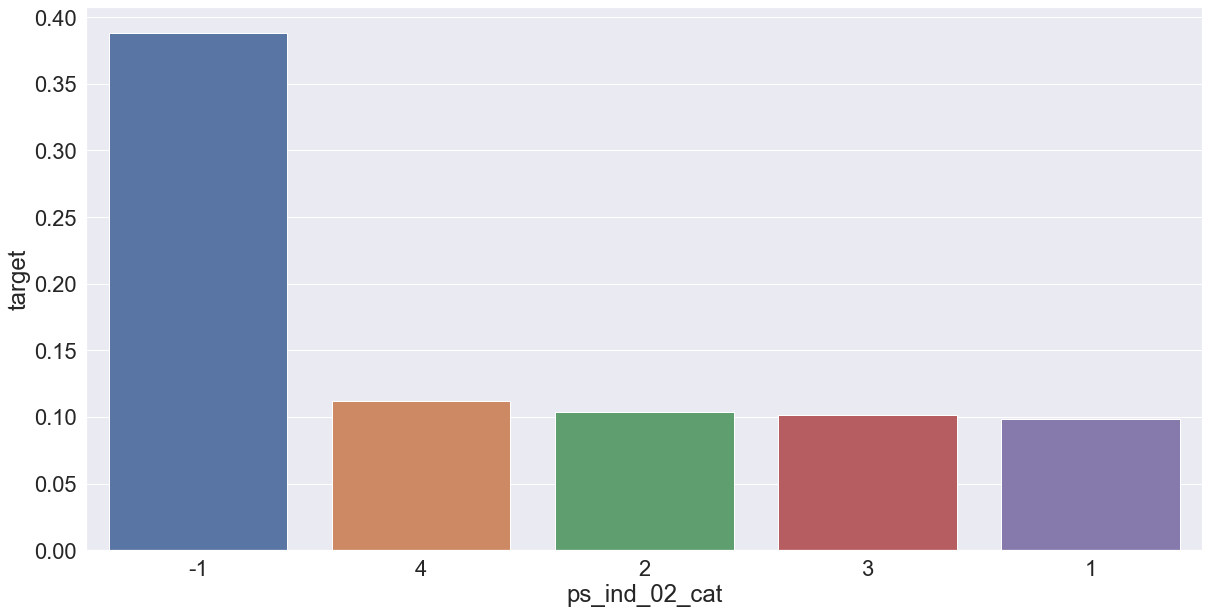

In [210]:
plt.figure()

fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(x=column, y='target', data=cat_perc, order=cat_perc[column])
# x축을 column으로, y축을 target, 그리고 순서는 cat_perc[column] 순서로

<Figure size 432x288 with 0 Axes>

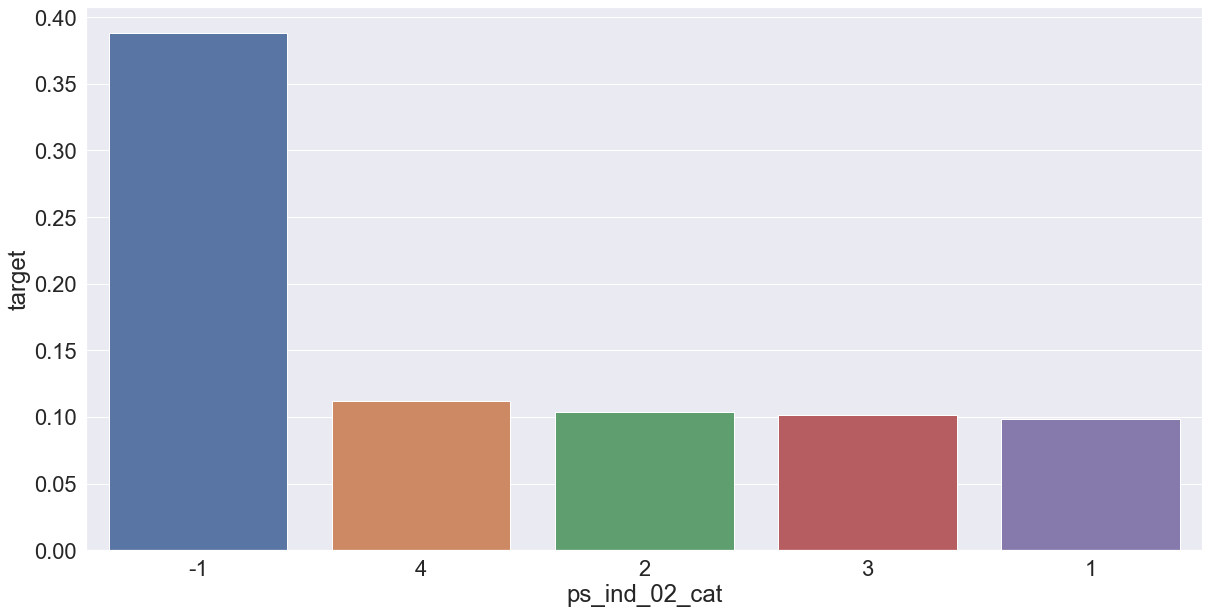

<Figure size 432x288 with 0 Axes>

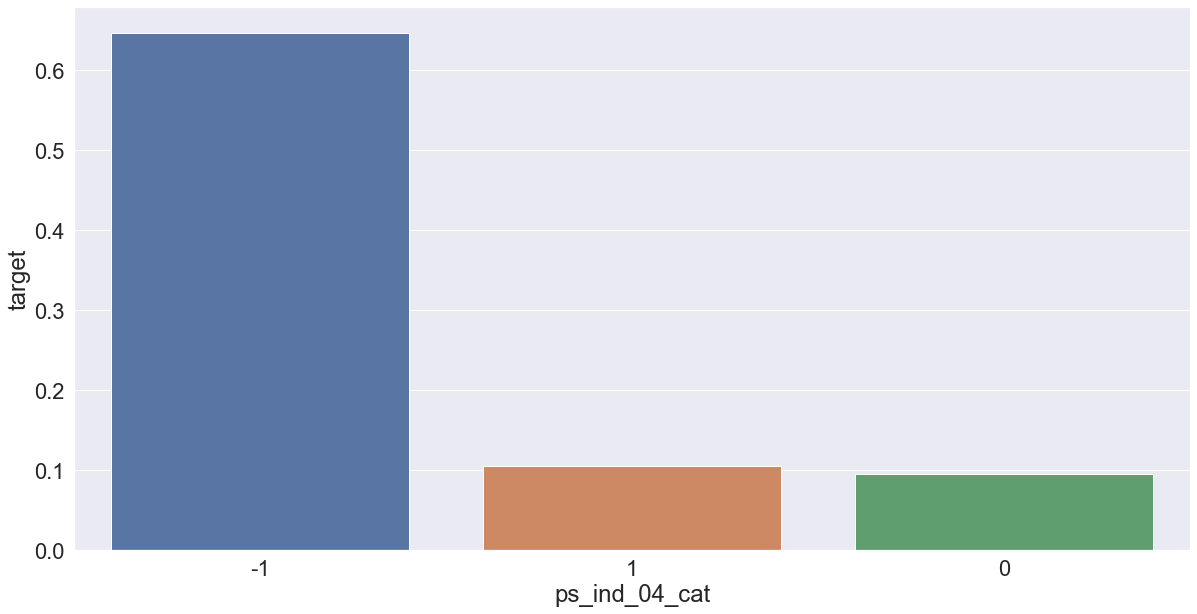

<Figure size 432x288 with 0 Axes>

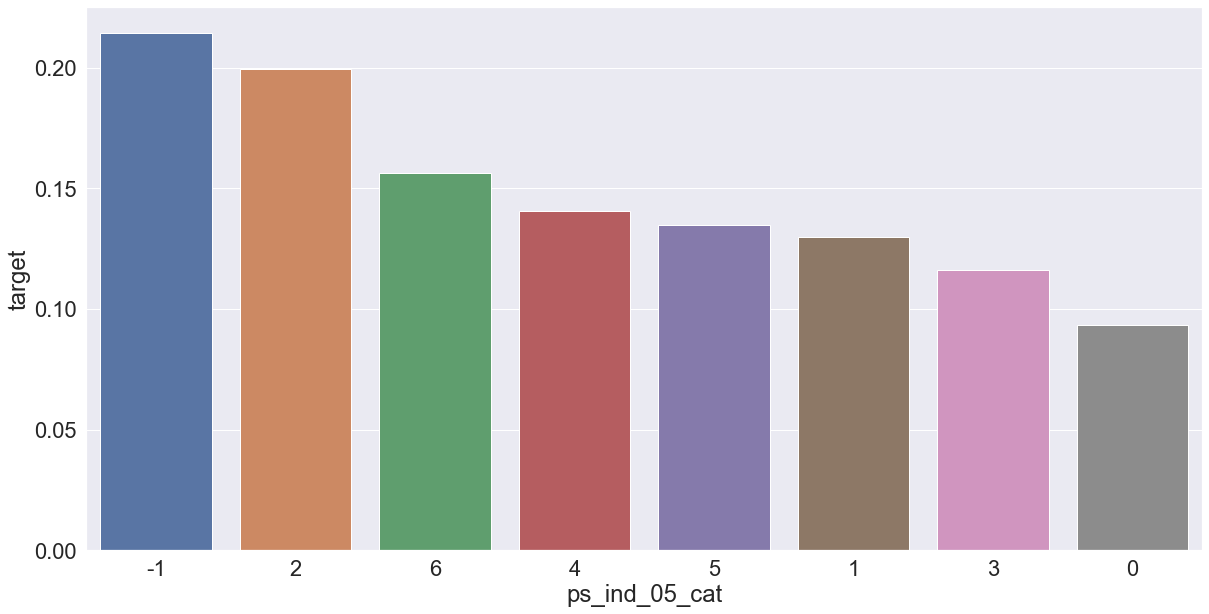

<Figure size 432x288 with 0 Axes>

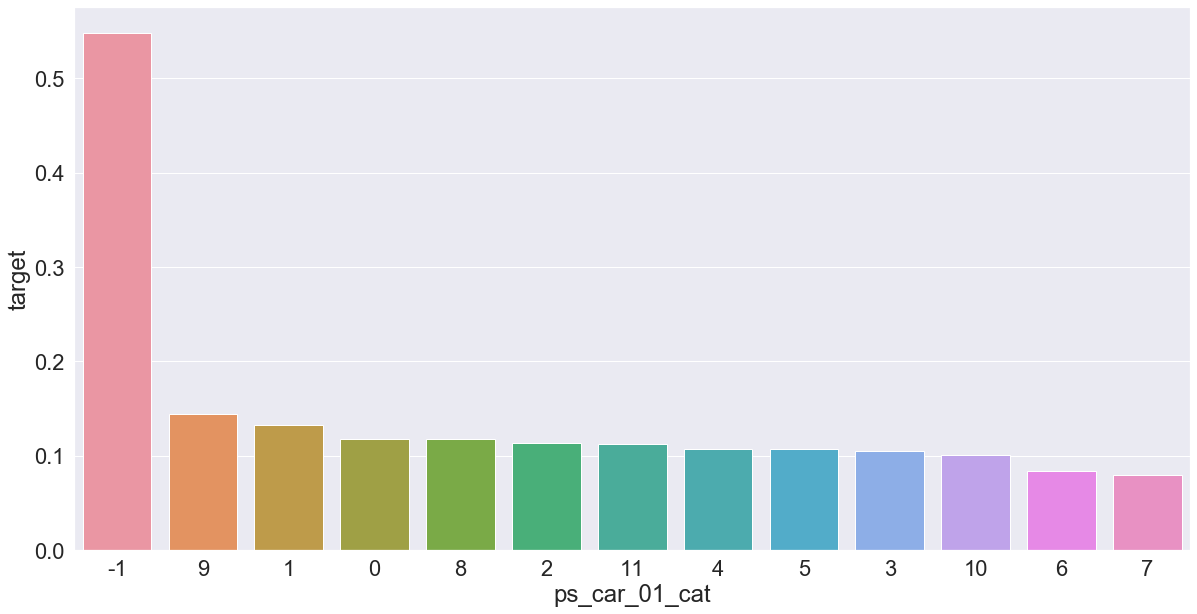

<Figure size 432x288 with 0 Axes>

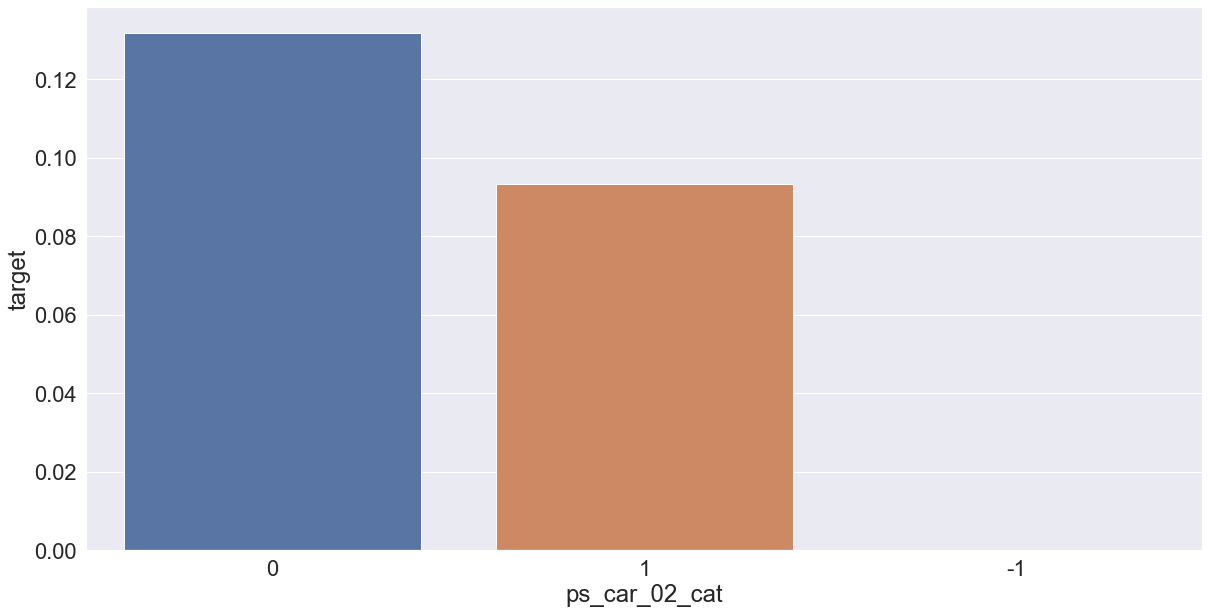

<Figure size 432x288 with 0 Axes>

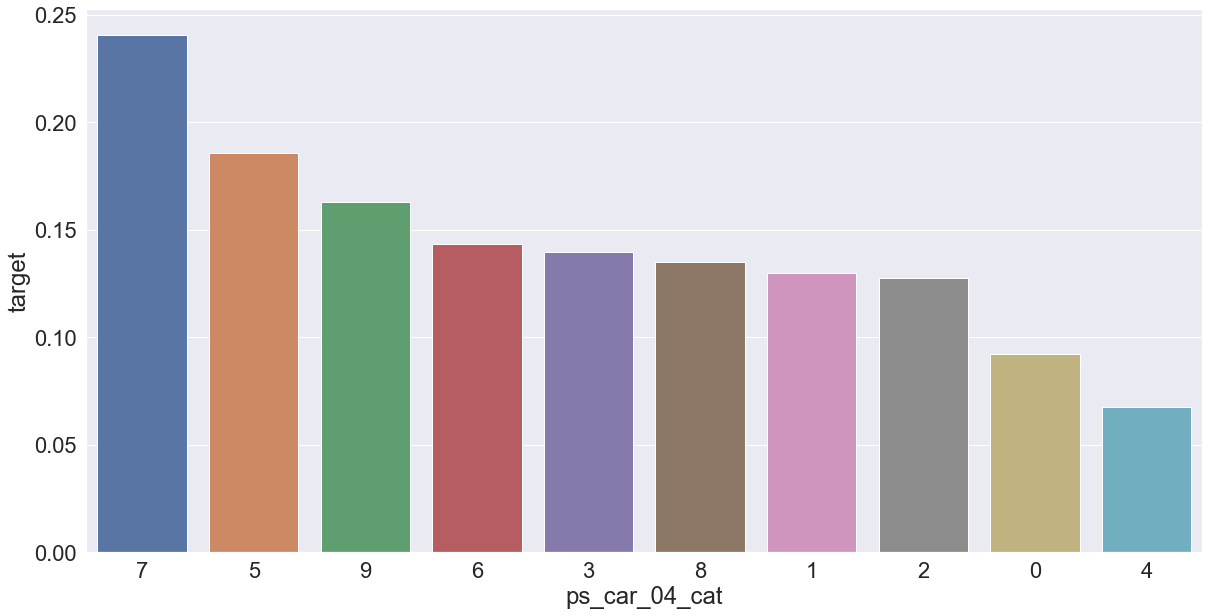

<Figure size 432x288 with 0 Axes>

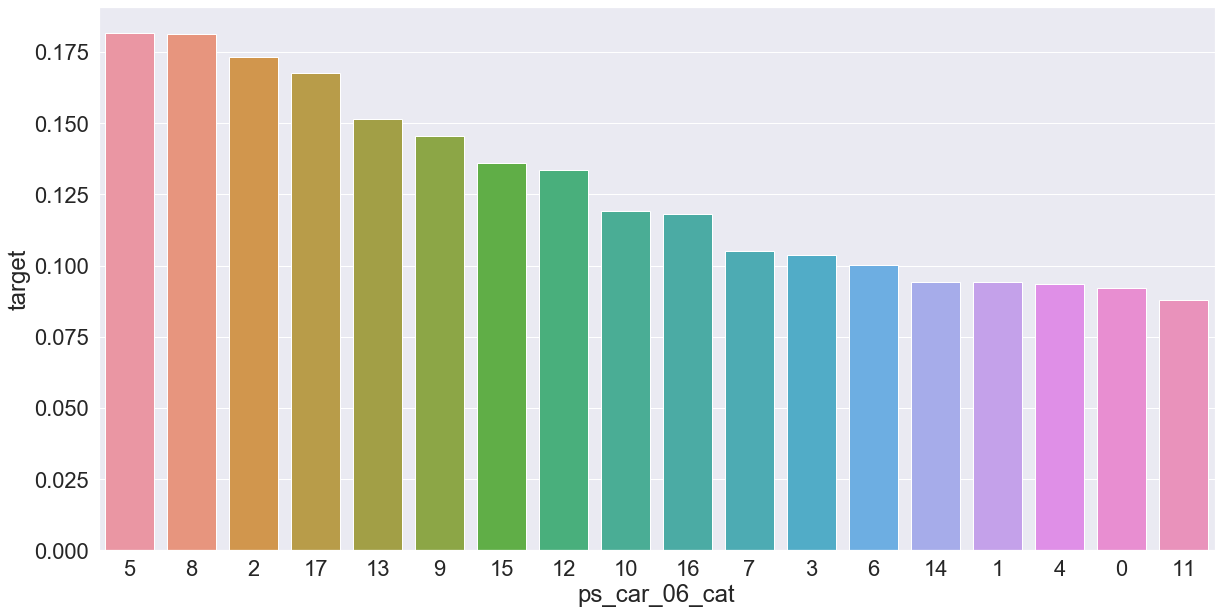

<Figure size 432x288 with 0 Axes>

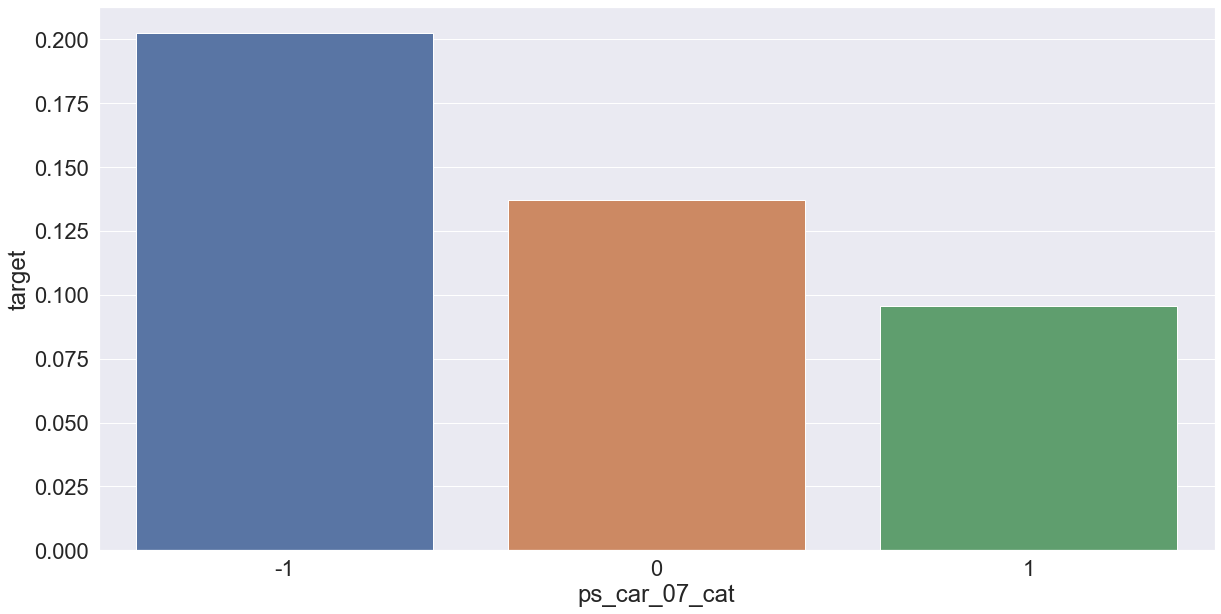

<Figure size 432x288 with 0 Axes>

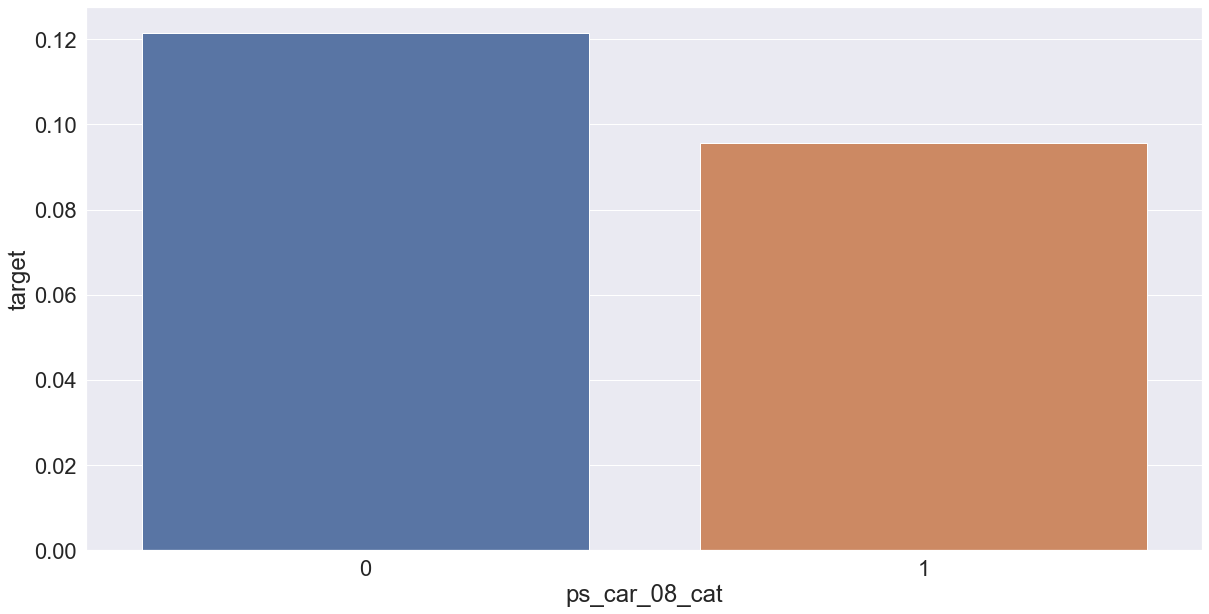

<Figure size 432x288 with 0 Axes>

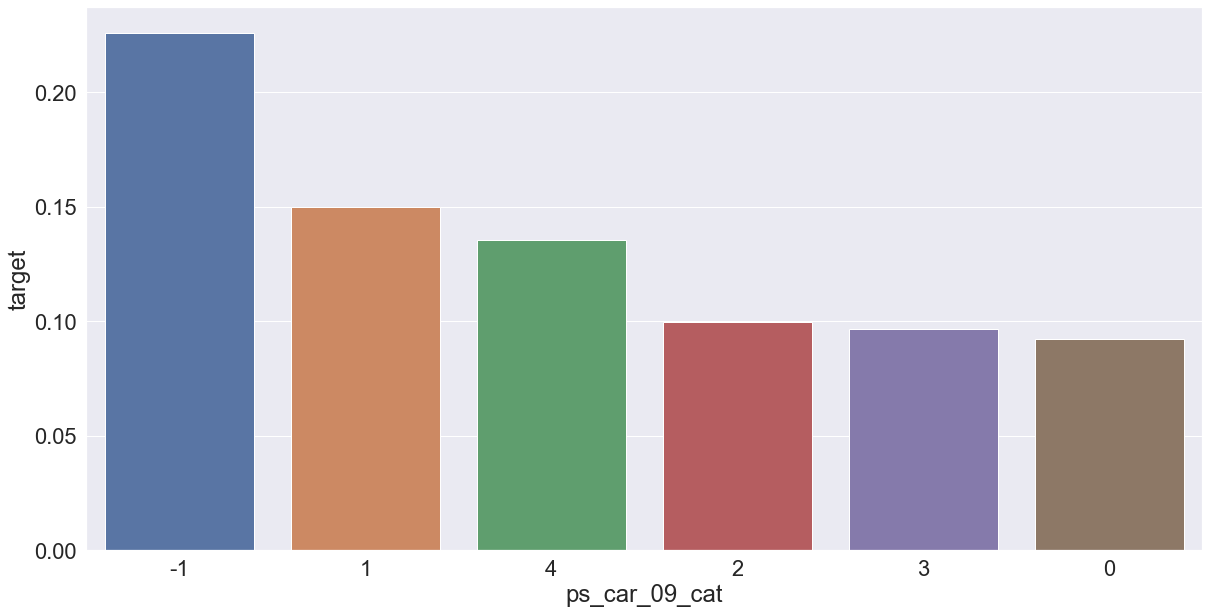

<Figure size 432x288 with 0 Axes>

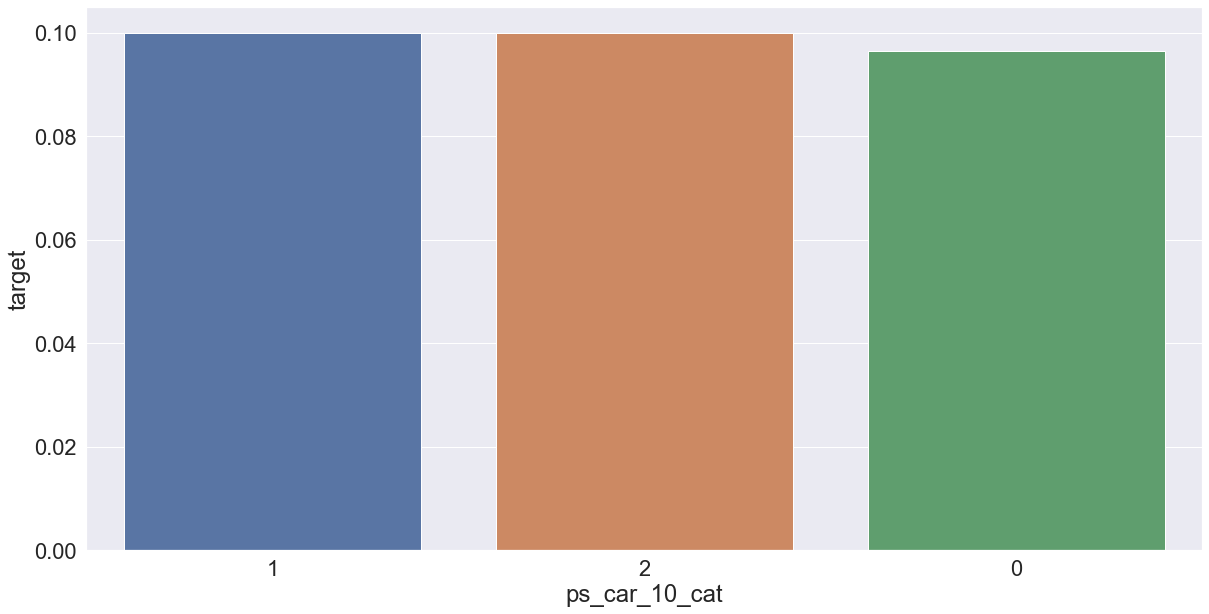

In [235]:
# 위를 종합

v = meta[(meta.level == 'nominal') & (meta.keep)].index

for column in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20, 10))
    
    cat_perc = train[[column, 'target']].groupby([column], as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    
    for i, p in enumerate(ax.patches):
        ax.annotate('{}'.format(cat_perc['target']['count'].values[i]),
                (p.get_height(), p.get_x()+0.5), fontsize=20)
    
    
    sns.barplot(x=column, y='target', data=cat_perc, order=cat_perc[column])
    sns.set(font_scale=2)
    
    plt.show()

- ps_ind_02_cat, ps_ind_04_cat 같은 경우 -1 (missing value)를 가지는 경우에 target값이 다른 값에 비해 큰 것을 볼 수 있다. 이는 좋은 변수가 될 수 있다.

- ps_car_02_cat 같은 경우는 -1의 target 값이 0 이다.

- 물론 이 값이 매우 적은 데이터 row로 이루어진 것일수 있으므로 count를 해보아야한다.

In [229]:
column = 'ps_car_02_cat'

cat_perc = train[[column, 'target']].groupby([column], as_index=False).agg(['mean','count'])
cat_perc

target        
                   mean   count
ps_car_02_cat                  
-1             0.000000       2
 0             0.131868   38000
 1             0.093233  178938

- 위와 같이 ps_car_02_cat 변수의 미싱밸류가 유의미한 것 처럼 보이나 샘플이 2개밖에 없는 경우가 있다.

- Missing value가 어느정도 의미를 지니는 것 같으니 채우지 않고 그냥 두자.

- 함부로 채우는 경우 변수에 Bias를 주게 될 수 있다.

In [49]:
sum   # 원핫 인코딩을 하면 12개의 변수가 178개의 변수로 바뀐다.

177

- 원핫인코딩으로 변수의 개수가 너무 많아지면 우선 연산이 늘어나고, 또 Tree 모델에서 깊이도 깊어지고 중요한 피처를 빨리 찾지 못하는 등의 문제점이 생길 수 있다.

- 따라서, mean 인코딩이나 Frequency 인코딩도 사용한다.

- ps_car_11_cat 외에 나머지는 원핫인코딩도 괜찮다.

## Encoding

In [184]:
train_series = train['ps_car_11_cat']
test_series = test['ps_car_11_cat']
target = train.target
min_samples_leaf = 100
smoothing = 10
noise_level = 0.01

In [185]:
# ps_car_!1_cat 변수와 target변수를 temp에 저장

temp = pd.concat([train_series, target], axis=1)
temp

,ps_car_11_cat,target
0,26,0
1,104,0
2,15,0
3,74,0
4,78,0
...,...,...
216935,104,1
216936,5,1
216937,104,1
216938,104,1


In [186]:
def max_min(x):
    return x.max() - x.min()

- 위에서 ps_car_11_cat 변수를 그룹바이하여 각 값에 대하여 mean, count 등 통계량을 정리

- agg 함수를 사용해 mean, count, std 등의 통계량을 뽑아올 수 있음

- 함수를 만들어 함수도 agg 안에 인자로 집어넣을수 있다.

In [187]:
averages = temp.groupby(by=train_series.name)[target.name].agg(['mean', 'count'])

# 오버피팅을 방지하는 기법, Smoothing
smoothing = 1 / (1 + np.exp(-(averages['count'] - min_samples_leaf) / smoothing))

In [188]:
prior = target.mean()   # target의 전체 평균

In [189]:
# 스무딩한 target값을 averages에 저장
averages[target.name] = prior * (1- smoothing) + averages['mean'] * smoothing

In [190]:
# 스무딩한 target값 제외한 것을 제거
averages.drop(['mean','count'], axis=1, inplace=True)

- train_series와 위에서 만든 averages(target값별로 그룹바이한 mean)을 merge해주는 것

- how='left'를 해주어야함 (원래의 series를 기준으로 해야 변동이 되지않음)

- merge후 이름바꾸고, fillna(prior=0.1) --> 널값이 있을경우 0.1로 채워줌

- Feature를 새로 만들고 합칠 때 매우 많이 쓰이는 코드

In [191]:
ft_train_series = pd.merge(train_series.to_frame(train_series.name),
         averages.reset_index().rename(columns={'index': target.name, target.name:'average'}),
         on=train_series.name, how='left')['average'].rename(train_series.name + '_mean').fillna(prior)

ft_train_series.index = train_series.index

In [192]:
ft_test_series = pd.merge(test_series.to_frame(test_series.name),
         averages.reset_index().rename(columns={'index': target.name, target.name:'average'}),
         on=test_series.name, how='left')['average'].rename(test_series.name + '_mean').fillna(prior)

ft_test_series.index = test_series.index

In [193]:
# noise를 섞어주기 (오버피팅 방지)

ft_train_series * (1 + 0.01 * np.random.randn(len(train_series)))

0         0.096062
1         0.119477
2         0.096898
3         0.086438
4         0.106700
            ...   
216935    0.119873
216936    0.113477
216937    0.121189
216938    0.120375
216939    0.068129
Name: ps_car_11_cat_mean, Length: 216940, dtype: float64

- Encoding 위의 과정을 하나의 함수로

In [194]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [195]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)

In [196]:
train['ps_car_11_cat_te'] = train_encoded   # 인코딩한것을 새로운 컬럼으로 추가
train.drop('ps_car_11_cat', axis=1, inplace=True)   # 기존것은 제거

meta.loc['ps_car_11_cat','keep'] = False  # meta 정보 업데이트

test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

- Mean Encoding
    - 장점: 트리모델에서 빠르게 학습이 가능하다. 특히 변수가 많을 때
    - 단점: Validation을 하기가 어렵다. 그리고 오버피팅되기 쉽다.(regularization을 사용해야 함)
    
    - 카테고리컬한 데이터라도 어느정도 Linear한 관계가 나타난다.

## EDA

In [197]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

In [198]:
for column in v:
    break

In [205]:
# column 마다 값별로 target값의 평균을 그룹바이
cat_perc = train[[column, 'target']].groupby([column], as_index=False).mean()

cat_perc

,ps_ind_02_cat,target
0,-1,0.388350
1,1,0.098190
2,2,0.104102
3,3,0.101746
4,4,0.112349


In [206]:
# 그 후 target값이 큰 순으로 정렬
cat_perc.sort_values(by='target', ascending=False, inplace=True)

In [211]:
sns.set(font_scale=2)   # 폰트 사이즈

<Figure size 432x288 with 0 Axes>

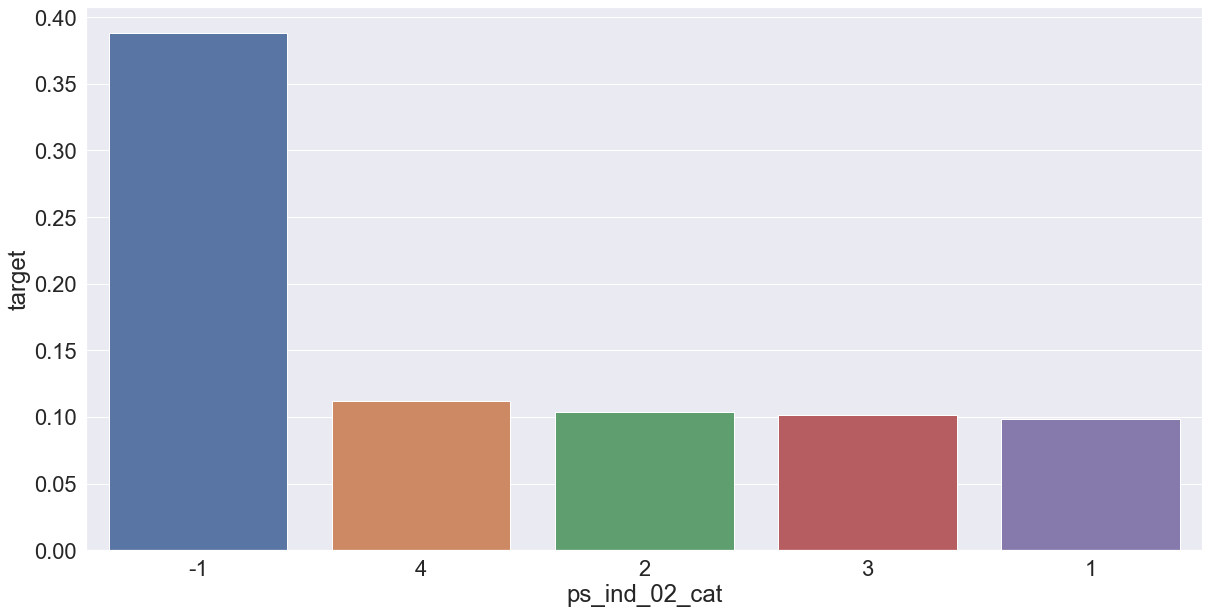

In [210]:
plt.figure()

fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(x=column, y='target', data=cat_perc, order=cat_perc[column])
# x축을 column으로, y축을 target, 그리고 순서는 cat_perc[column] 순서로

<Figure size 432x288 with 0 Axes>

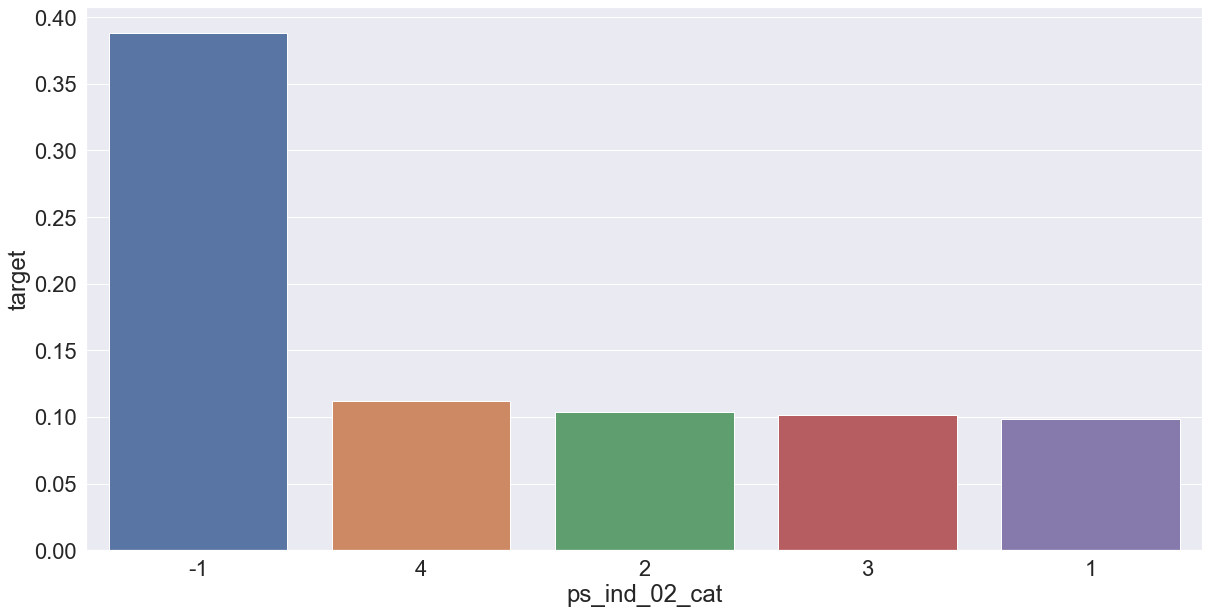

<Figure size 432x288 with 0 Axes>

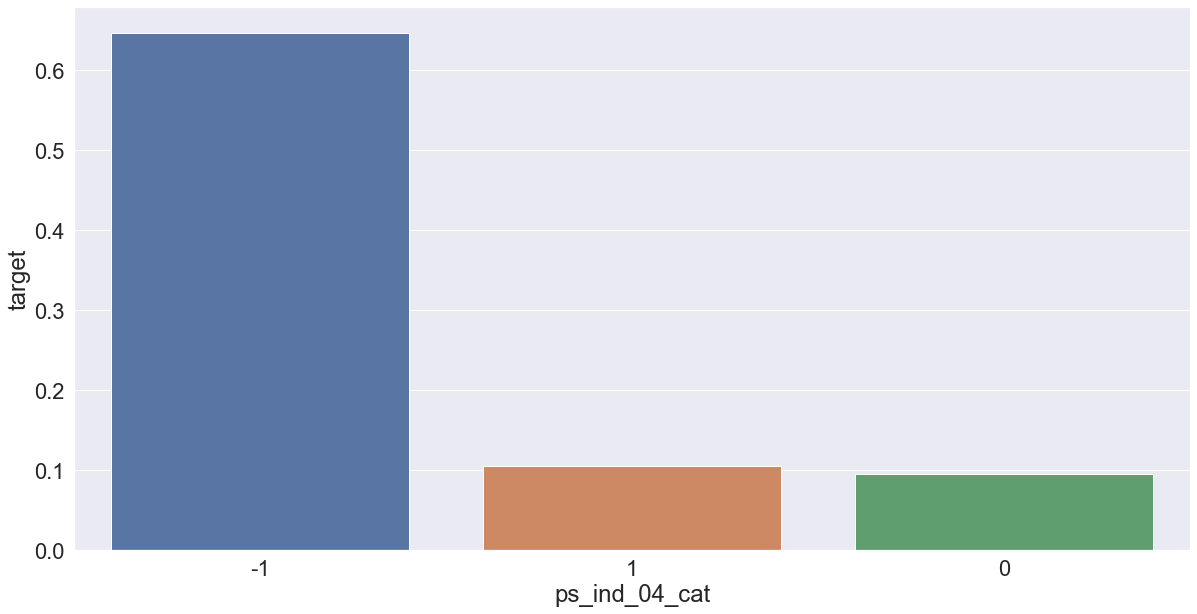

<Figure size 432x288 with 0 Axes>

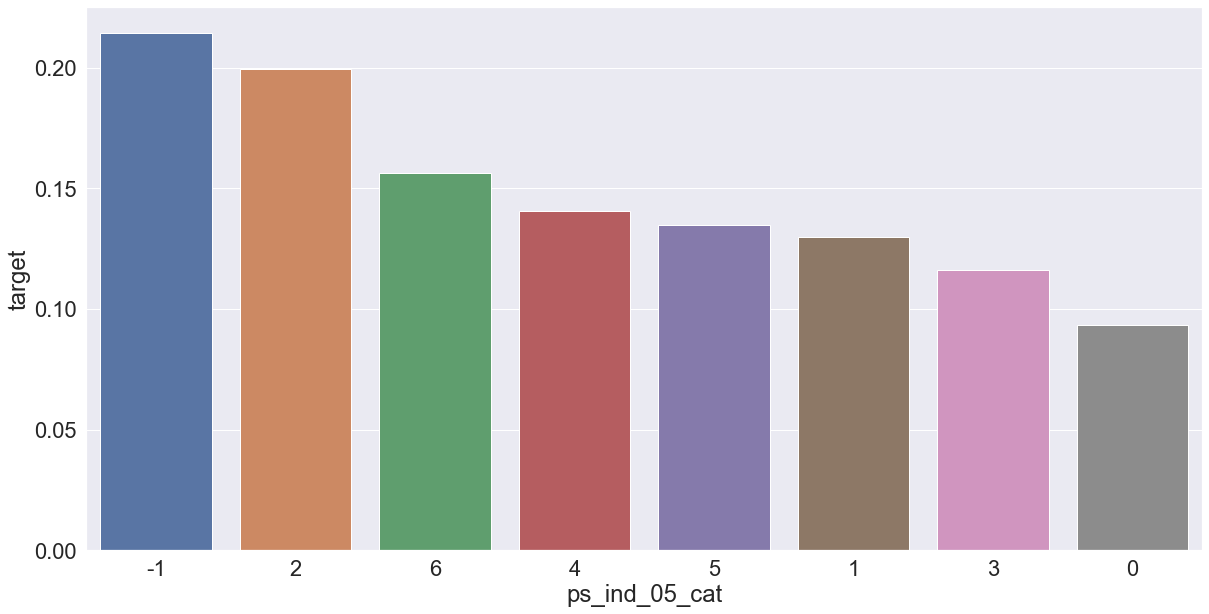

<Figure size 432x288 with 0 Axes>

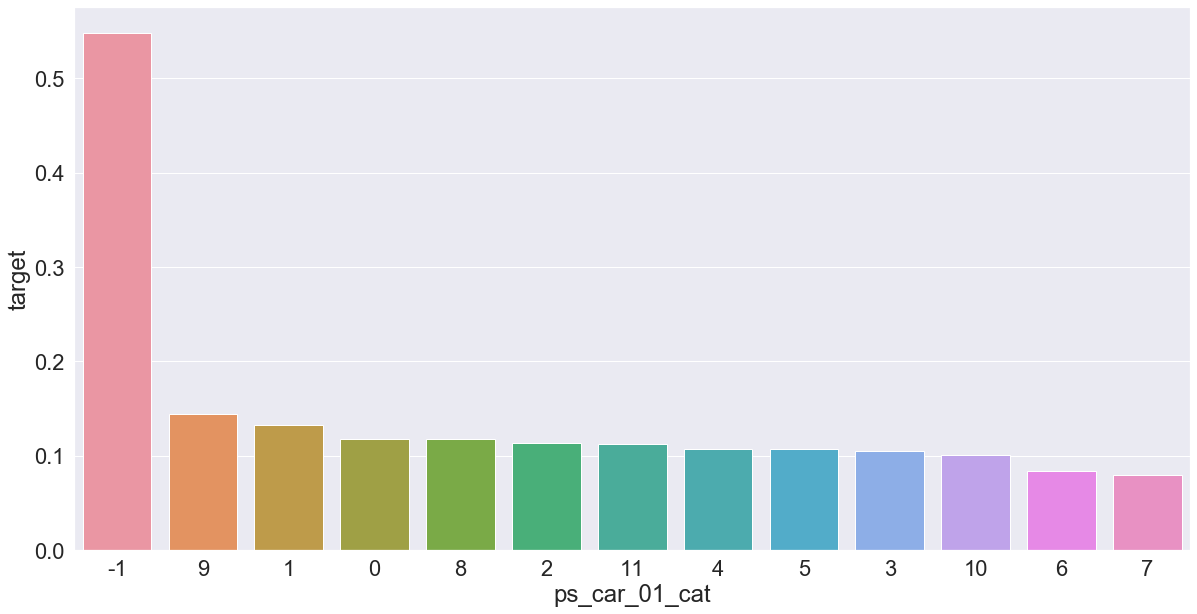

<Figure size 432x288 with 0 Axes>

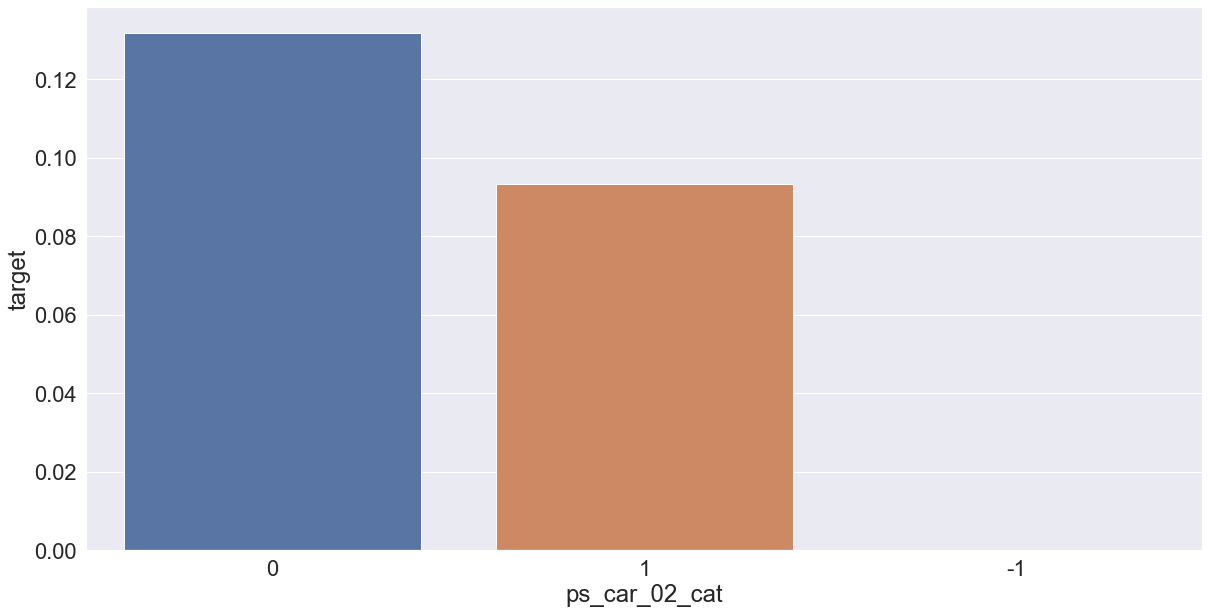

<Figure size 432x288 with 0 Axes>

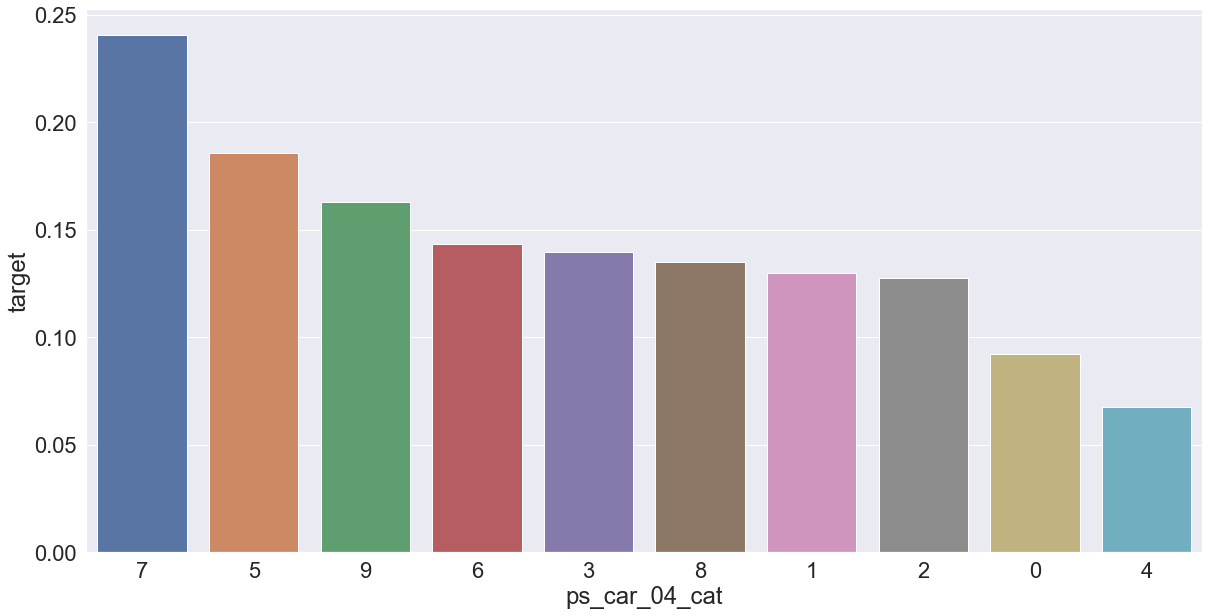

<Figure size 432x288 with 0 Axes>

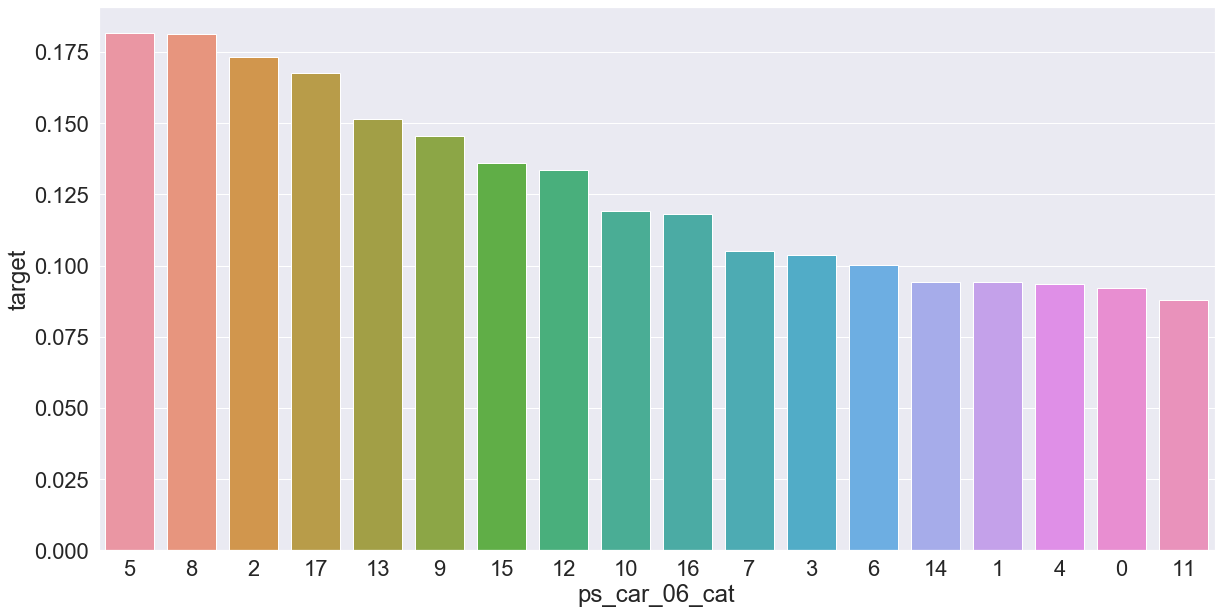

<Figure size 432x288 with 0 Axes>

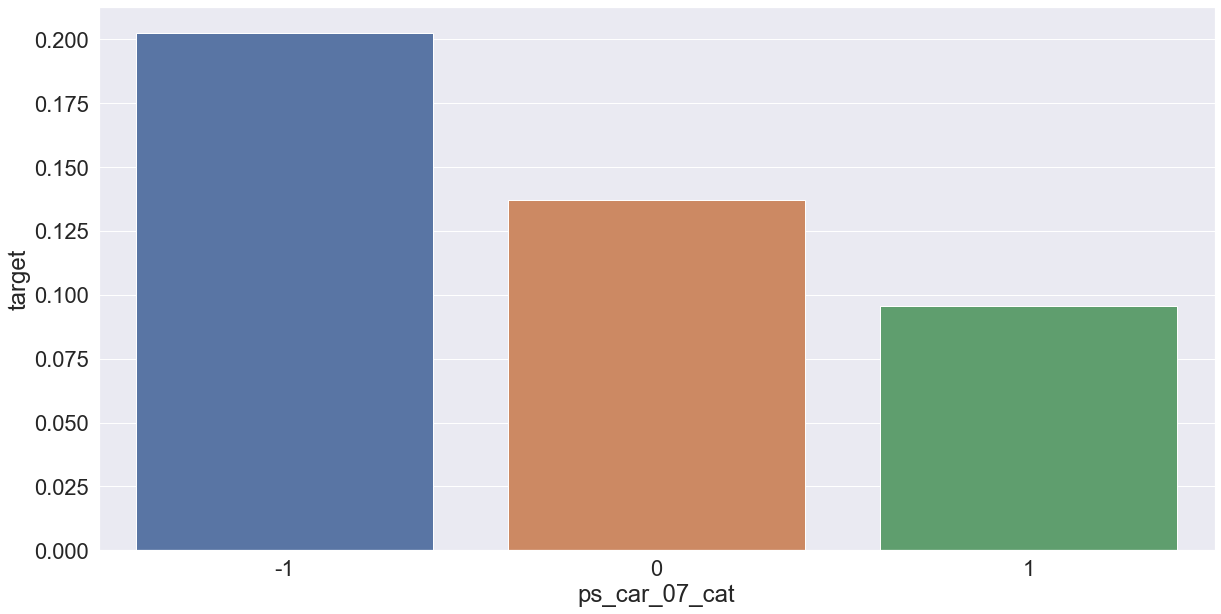

<Figure size 432x288 with 0 Axes>

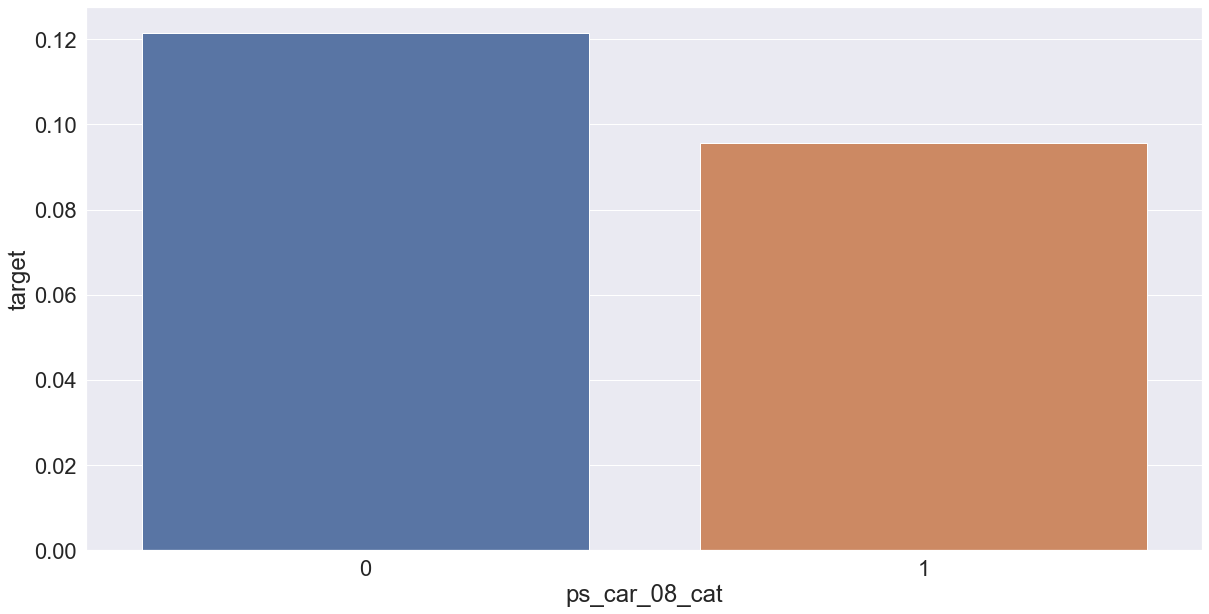

<Figure size 432x288 with 0 Axes>

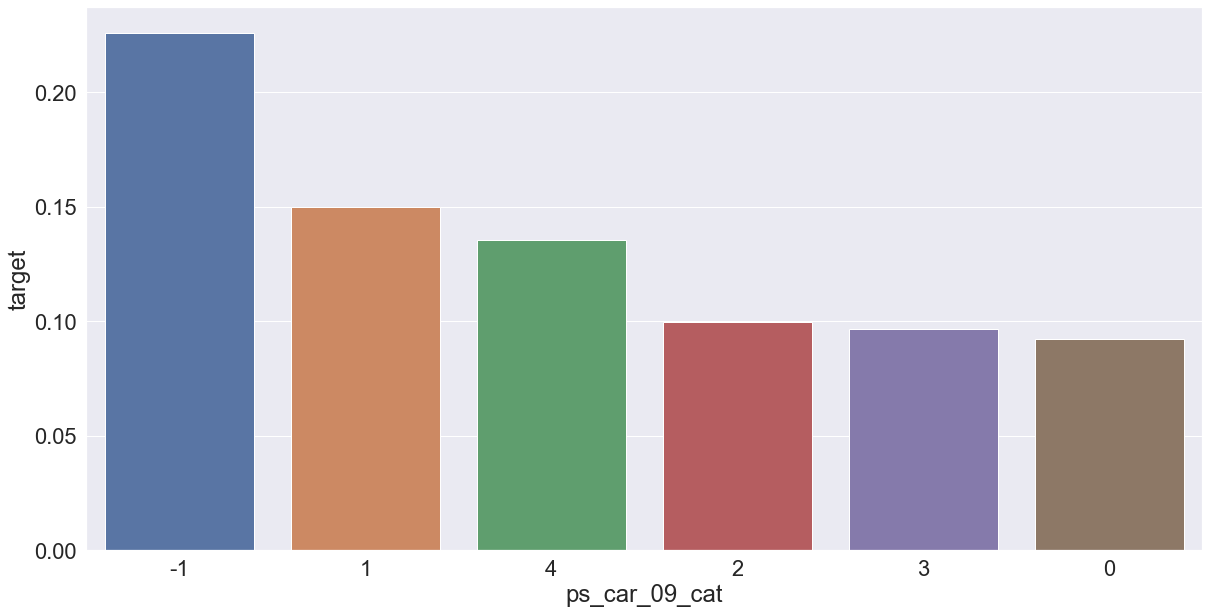

<Figure size 432x288 with 0 Axes>

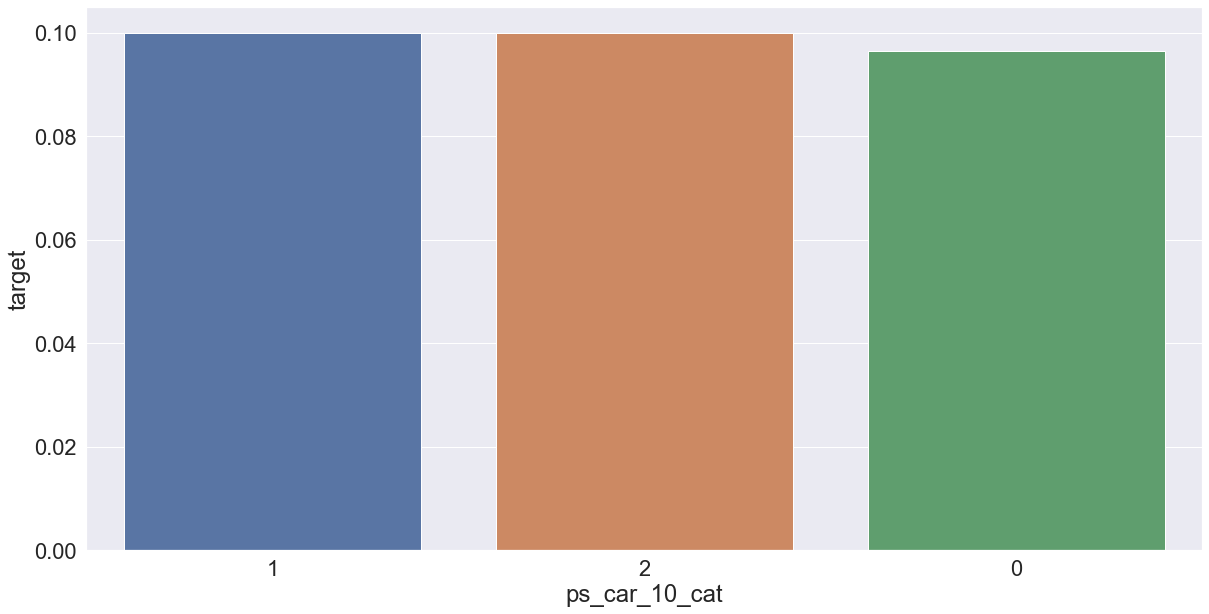

In [235]:
# 위를 종합

v = meta[(meta.level == 'nominal') & (meta.keep)].index

for column in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20, 10))
    
    cat_perc = train[[column, 'target']].groupby([column], as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    
    for i, p in enumerate(ax.patches):
        ax.annotate('{}'.format(cat_perc['target']['count'].values[i]),
                (p.get_height(), p.get_x()+0.5), fontsize=20)
    
    
    sns.barplot(x=column, y='target', data=cat_perc, order=cat_perc[column])
    sns.set(font_scale=2)
    
    plt.show()

- ps_ind_02_cat, ps_ind_04_cat 같은 경우 -1 (missing value)를 가지는 경우에 target값이 다른 값에 비해 큰 것을 볼 수 있다. 이는 좋은 변수가 될 수 있다.

- ps_car_02_cat 같은 경우는 -1의 target 값이 0 이다.

- 물론 이 값이 매우 적은 데이터 row로 이루어진 것일수 있으므로 count를 해보아야한다.

In [229]:
column = 'ps_car_02_cat'

cat_perc = train[[column, 'target']].groupby([column], as_index=False).agg(['mean','count'])
cat_perc

target        
                   mean   count
ps_car_02_cat                  
-1             0.000000       2
 0             0.131868   38000
 1             0.093233  178938

- 위와 같이 ps_car_02_cat 변수의 미싱밸류가 유의미한 것 처럼 보이나 샘플이 2개밖에 없는 경우가 있다.

- Missing value가 어느정도 의미를 지니는 것 같으니 채우지 않고 그냥 두자.

- 함부로 채우는 경우 변수에 Bias를 주게 될 수 있다.